In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

In [4]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# DATA PREPROCESSING
from data_preprocessing import getData
schema, number_of_buildings, number_of_actions, random_seed = getData(
    active_actions=['electrical_storage', 'dhw_storage'],
    number_of_buildings=2,
    number_of_days=30,
    root_path='../'
)

Active buildings in the schema: 
Building_1
Building_2


Active observations in the schema: 
day_type
hour
outdoor_dry_bulb_temperature
outdoor_dry_bulb_temperature_predicted_6h
outdoor_dry_bulb_temperature_predicted_12h
outdoor_dry_bulb_temperature_predicted_24h
outdoor_relative_humidity
outdoor_relative_humidity_predicted_6h
outdoor_relative_humidity_predicted_12h
outdoor_relative_humidity_predicted_24h
diffuse_solar_irradiance
diffuse_solar_irradiance_predicted_6h
diffuse_solar_irradiance_predicted_12h
diffuse_solar_irradiance_predicted_24h
direct_solar_irradiance
direct_solar_irradiance_predicted_6h
direct_solar_irradiance_predicted_12h
direct_solar_irradiance_predicted_24h
carbon_intensity
indoor_dry_bulb_temperature
indoor_relative_humidity
non_shiftable_load
solar_generation
dhw_storage_soc
electricity_pricing
cooling_device_cop
cooling_demand
dhw_demand
cooling_electricity_consumption
dhw_electricity_consumption
indoor_dry_bulb_temperature_delta


Active actions in the schema: 

In [8]:
from citylearn.citylearn import CityLearnEnv
from stable_baselines3.dqn import DQN
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper
from rewardFunctions.consumptionDeviationRewardFunction import CustomRewardFunction
from wrappers.DQNActionWrapper import DQNActionWrapper

env = CityLearnEnv(schema, central_agent=True)

# set reward function
env.reward_function = CustomRewardFunction(env=env)

# wrap environment
env = NormalizedObservationWrapper(env)
env = StableBaselines3Wrapper(env)

action_bins = {'electrical_storage': 21, 'dhw_storage': 21}

action_bin_sizes = []
for b in env.buildings:
    action_bin_sizes.append(action_bins)

# discretize action space
env = DQNActionWrapper(env, action_bin_sizes)

model = DQN.load("../saved/dqn/dqn_default.zip", env=env, seed=random_seed)

observations = env.reset()
actions_list = []
rewards_list = []

while not env.done:
    actions, _ = model.predict(observations, deterministic=True)
    observations, reward, _, _ = env.step(actions)
    actions_list.append(actions)
    rewards_list.append(reward)

kpis = env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable

name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,-0.0000,0.0000,-0.0000
annual_peak_average,NaN,NaN,0.9784
carbon_emissions_total,1.1199,1.0716,1.0958
cost_total,1.1139,1.0874,1.1007
daily_one_minus_load_factor_average,NaN,NaN,1.0587
daily_peak_average,NaN,NaN,1.1574
discomfort_delta_average,-3.2760,-1.7385,-2.5072
discomfort_delta_maximum,0.8456,1.1519,0.9988
discomfort_delta_minimum,-6.6930,-5.5470,-6.1200


: 

In [14]:
positive_values = [value for value in env.net_electricity_consumption if value > 0]
negative_values = [value for value in env.net_electricity_consumption if value < 0]

positive_sum = sum(positive_values)
negative_sum = sum(negative_values)

print("Sum of positive values:", positive_sum)
print("Sum of negative values:", negative_sum)
print("Sum of all values:", sum(env.net_electricity_consumption))

Sum of positive values: 1073.6750562302768
Sum of negative values: -41.01931515336037
Sum of all values: 1032.6557410769165


In [15]:
positive_values = [value for value in env.net_electricity_consumption_without_storage if value > 0]
negative_values = [value for value in env.net_electricity_consumption_without_storage if value < 0]

positive_sum = sum(positive_values)
negative_sum = sum(negative_values)

print("Sum of positive values:", positive_sum)
print("Sum of negative values:", negative_sum)
print("Sum of all values:", sum(env.net_electricity_consumption_without_storage))

Sum of positive values: 1014.1132938563824
Sum of negative values: -16.333162792026997
Sum of all values: 997.7801310643554


In [18]:
change = sum([value for value in env.net_electricity_consumption if value > 0]) / sum([value for value in env.net_electricity_consumption_without_storage if value > 0])
print("Change:", change)

Change: 1.0587328484250493


In [19]:
sum_of_rewards = sum(rewards_list)
print("Sum of rewards:", sum_of_rewards)

Sum of rewards: -19278.828871556747


In [25]:
sum_valuesA = sum(valA for valA, valB in zip(env.electrical_storage_electricity_consumption, env.net_electricity_consumption) if valB < 0)

print("Sum of valuesA where valuesB is negative:", sum_valuesA)

Sum of valuesA where valuesB is negative: -52.86690349964192


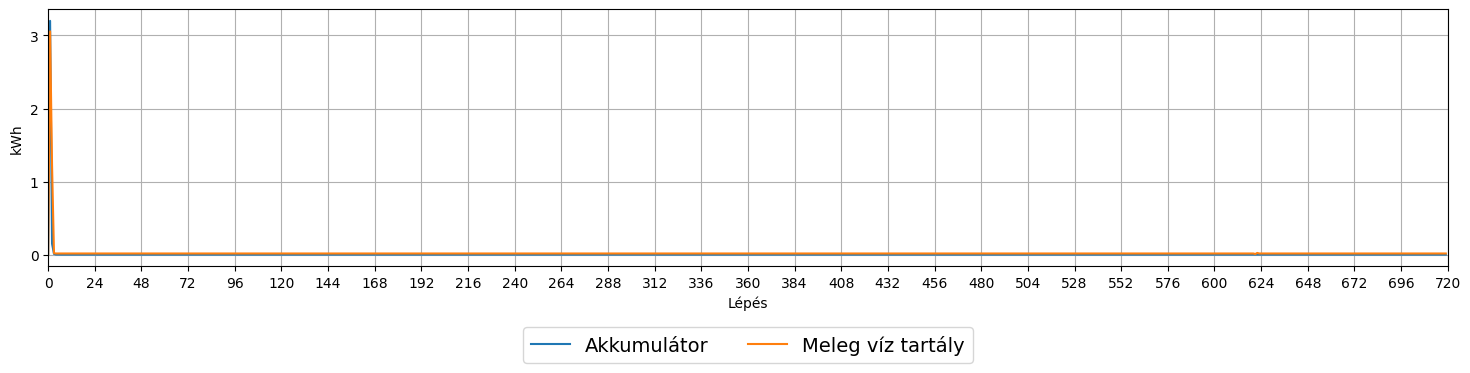

In [7]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

envs = {
    # 'RBC': rbc_results['env'],
    # 'DQN': dqn_results['env'],
    'SAC': env,
    # 'A2C': a2c_results['env'],
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_results['env']
}

figsize = (15, 4)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption
    x = range(len(y))
    # ax.plot(x, y, label=k)

y = v.electrical_storage_electricity_consumption
ax.plot(x, y, label='Akkumulátor')
y = v.dhw_storage_electricity_consumption
ax.plot(x, y, label='Meleg víz tartály')

# baseline = sac_results['env'].net_electricity_consumption_without_storage
# y_difference = [y - base for y, base in zip(v.net_electricity_consumption, baseline)]
# ax.plot(x, y_difference, label=k)

ax.set_xlabel('Lépés')
ax.set_ylabel('kWh')
ax.set_xlim(0, 720)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, prop={'size': 14})
plt.rcParams.update({'font.size': 12})

plt.grid()
plt.tight_layout()

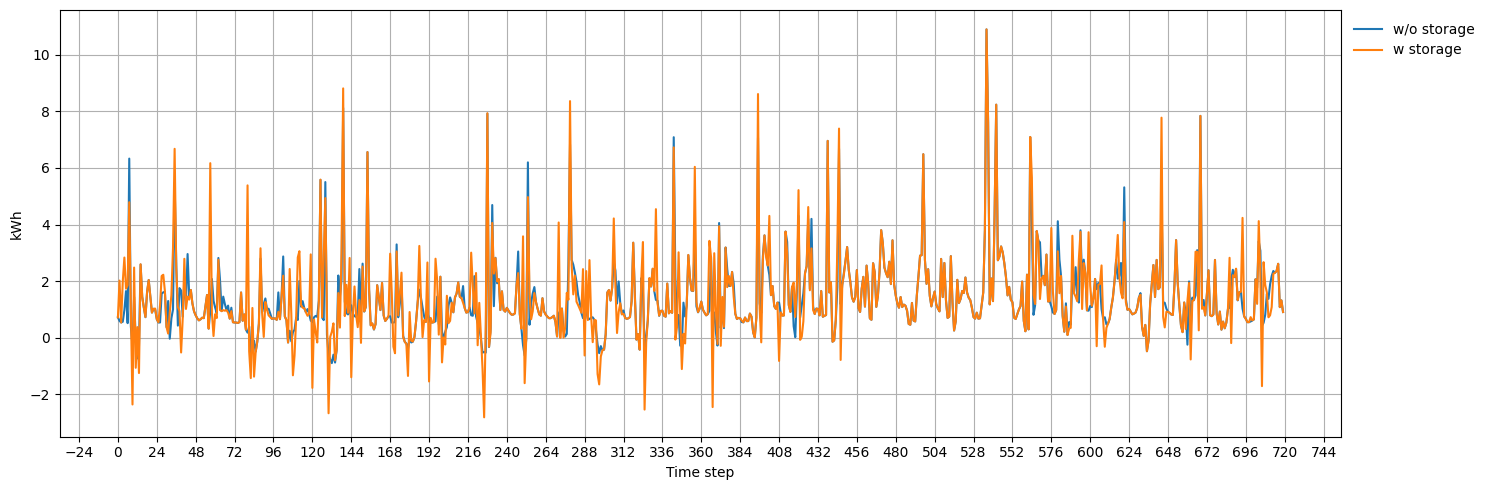

In [22]:
import matplotlib.ticker as ticker
%matplotlib inline

envs = {
    # 'RBC': rbc_results['env'],
    # 'DQN': dqn_results['env'],
    'SAC': env,
    # 'A2C': a2c_results['env'],
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption_without_storage
    x = range(len(y))
    ax.plot(x, y, label="w/o storage")
    y = v.net_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label="w storage")

ax.set_xlabel('Time step')
ax.set_ylabel('kWh')
# ax.set_xlim(120, 160)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
plt.grid()

plt.tight_layout()

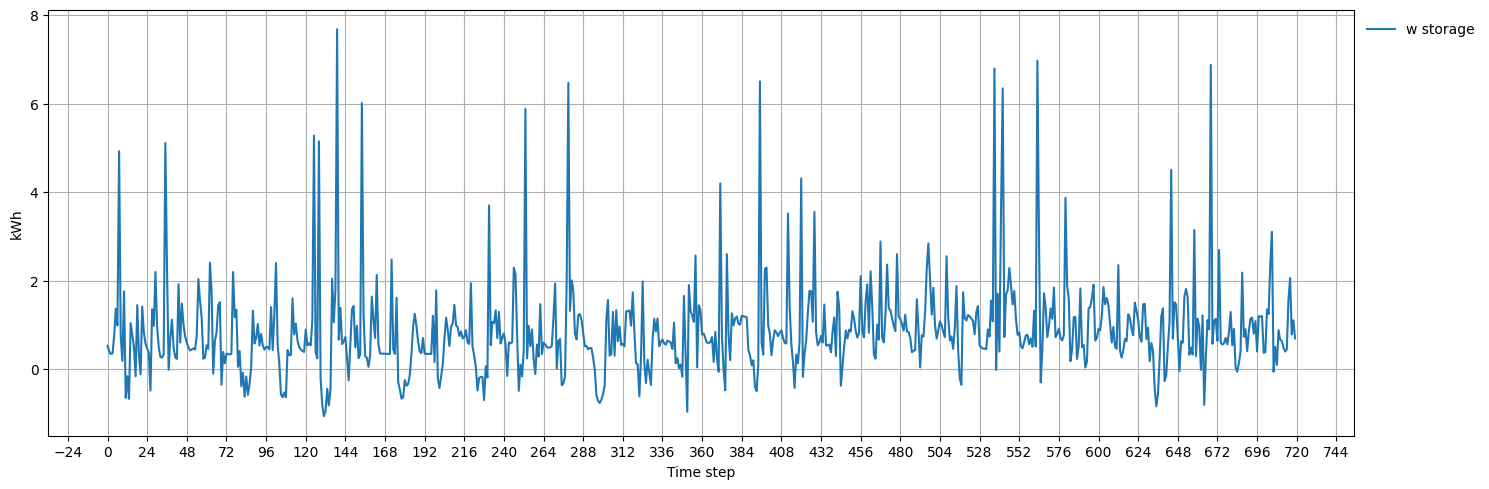

In [13]:
import matplotlib.ticker as ticker
%matplotlib inline

envs = {
    # 'RBC': rbc_results['env'],
    # 'DQN': dqn_results['env'],
    'SAC': env,
    # 'A2C': a2c_results['env'],
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption_without_storage
    x = range(len(y))
    # ax.plot(x, y, label="w/o storage")
    y = v.net_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label="w storage")

ax.set_xlabel('Time step')
ax.set_ylabel('kWh')
# ax.set_xlim(120, 160)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
plt.grid()

plt.tight_layout()

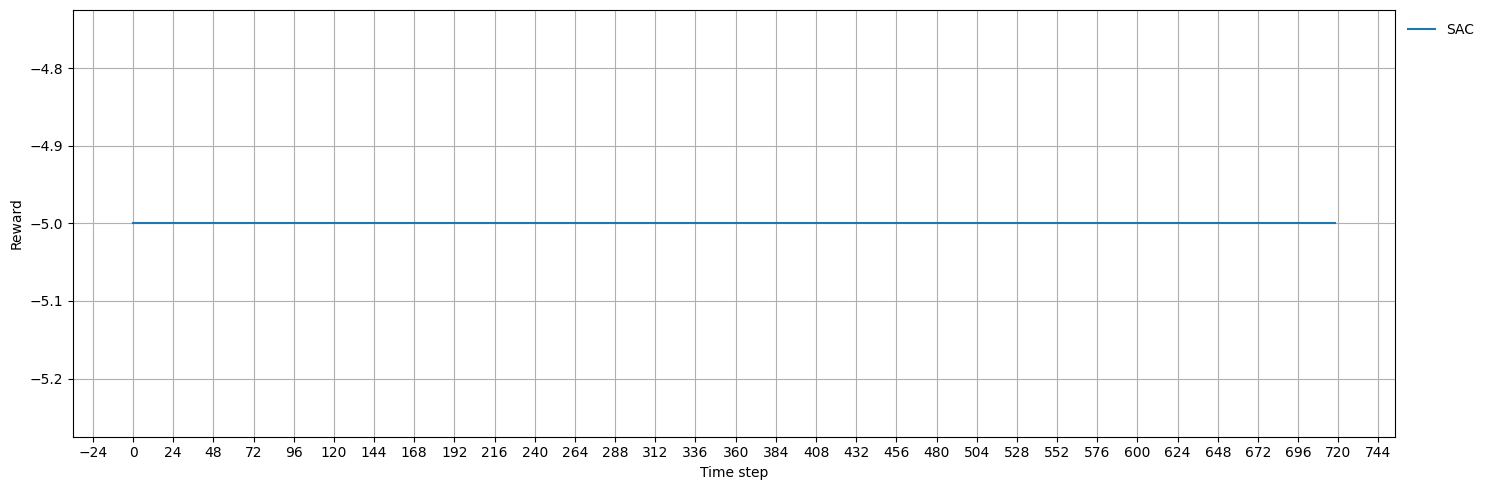

In [14]:
import matplotlib.ticker as ticker
%matplotlib inline

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

y = rewards_list
x = range(len(y))
ax.plot(x, y, label=k)

ax.set_xlabel('Time step')
ax.set_ylabel('Reward')
# ax.set_ylim(-2, 3)
# ax.set_xlim(120, 160)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
plt.grid()

plt.tight_layout()

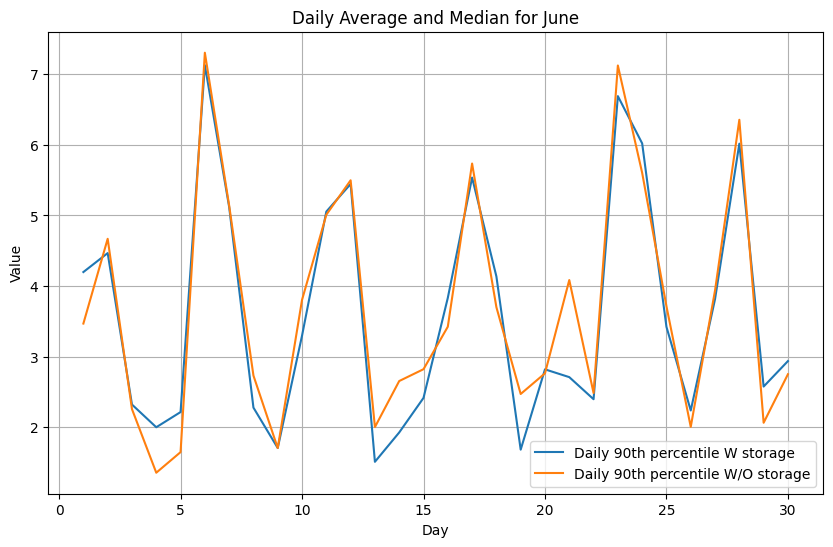

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

hourly_data_with_storage = pd.DataFrame({'value': env.net_electricity_consumption})
daily_data_with_storage = [hourly_data_with_storage[i:i+24] for i in range(0, len(hourly_data_with_storage), 24)]

daily_averages_with_storage = [day.mean() for day in daily_data_with_storage]
daily_medians_with_storage = [day.median() for day in daily_data_with_storage]
daily_90th_percentiles_with_storage = [np.percentile(day, 99) for day in daily_data_with_storage]


hourly_data_without_storage = pd.DataFrame({'value': env.net_electricity_consumption_without_storage})
daily_data_without_storage = [hourly_data_without_storage[i:i+24] for i in range(0, len(hourly_data_without_storage), 24)]

daily_averages_without_storage = [day.mean() for day in daily_data_without_storage]
daily_medians_without_storage = [day.median() for day in daily_data_without_storage]
daily_90th_percentiles_without_storage = [np.percentile(day, 99) for day in daily_data_without_storage]

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(daily_averages_with_storage) + 1), daily_averages_with_storage, label='Daily Average W storage')
# plt.plot(range(1, len(daily_medians_with_storage) + 1), daily_medians_with_storage, label='Daily Median W storage')
plt.plot(range(1, len(daily_90th_percentiles_with_storage) + 1), daily_90th_percentiles_with_storage, label='Daily 90th percentile W storage')
# plt.plot(range(1, len(daily_averages_without_storage) + 1), daily_averages_without_storage, label='Daily Average W/O storage')
# plt.plot(range(1, len(daily_medians_without_storage) + 1), daily_medians_without_storage, label='Daily Median W/O storage')
plt.plot(range(1, len(daily_90th_percentiles_without_storage) + 1), daily_90th_percentiles_without_storage, label='Daily 90th percentile W/O storage')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Daily Average and Median for June')
plt.legend()
plt.grid(True)
plt.show()

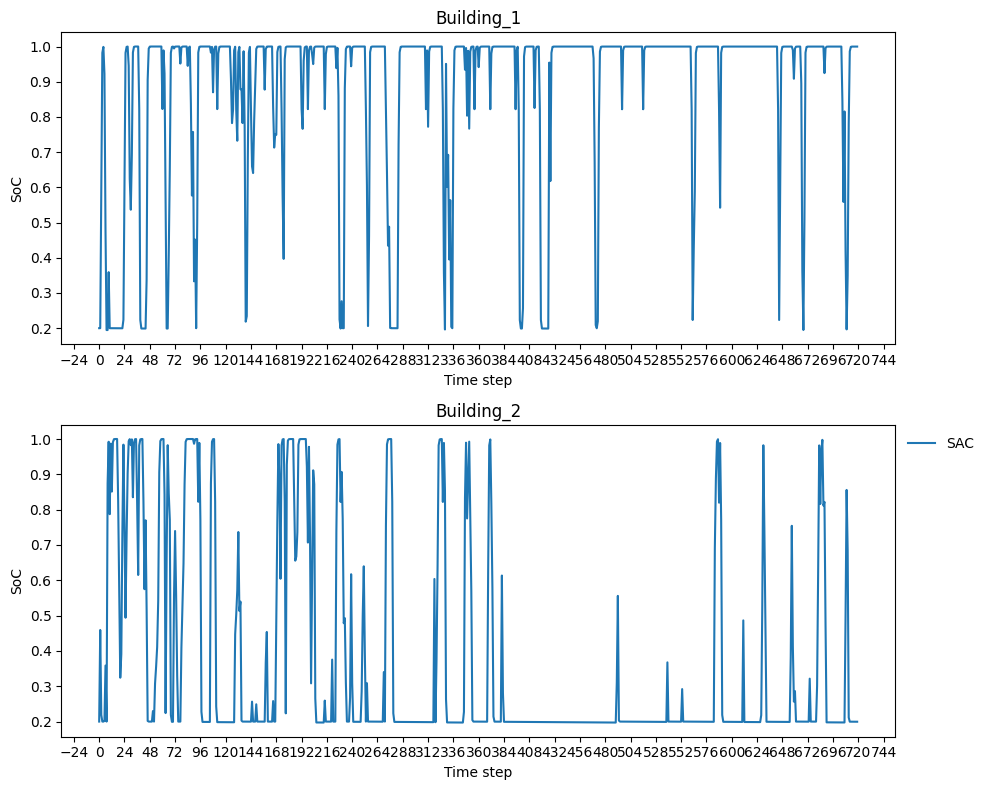

In [26]:
import math
%matplotlib inline

envs = {
    # 'DQN': dqn_env,
    'SAC': env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

building_count = len(list(envs.values())[0].buildings)
column_count_limit = 1
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
figsize = (10.0*column_count, 4*row_count)
fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

for i, ax in enumerate(fig.axes):
    for k, v in envs.items():
        soc = np.array(v.buildings[i].electrical_storage.soc)
        capacity = v.buildings[i].electrical_storage.capacity_history[0]
        y = soc
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_title(v.buildings[i].name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('SoC')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

    if i == building_count - 1:
        ax.legend(
            loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
        )
    else:
        ax.legend().set_visible(False)


plt.tight_layout()